### Preparing the dataframe 

In [1]:
import pandas as pd
import glob

In [2]:
df_true = pd.DataFrame(columns = ['name','flag'])
df_false = pd.DataFrame(columns = ['name','flag'])

df_true['name'] = glob.glob(r'/Users/krish/ljmu/1.data/sampletiled/ts/*.jpg')
df_true.flag = 1

df_false['name'] = glob.glob(r'/Users/krish/ljmu/1.data/sampletiled/false/*.jpg')
df_false.flag = 0

df = df_true.append(df_false)

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_22547/3209451503.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_true.append(df_false)


In [3]:
df_true.shape

(3215, 2)

In [4]:
df_false.shape

(3875, 2)

In [5]:
df

,name,flag
0,/Users/krish/ljmu/1.data/sampletiled/ts/905_0_...,1
1,/Users/krish/ljmu/1.data/sampletiled/ts/889_0_...,1
2,/Users/krish/ljmu/1.data/sampletiled/ts/1434_0...,1
3,/Users/krish/ljmu/1.data/sampletiled/ts/5708_0...,1
4,/Users/krish/ljmu/1.data/sampletiled/ts/100_0_...,1
...,...,...
3870,/Users/krish/ljmu/1.data/sampletiled/false/238...,0
3871,/Users/krish/ljmu/1.data/sampletiled/false/197...,0
3872,/Users/krish/ljmu/1.data/sampletiled/false/198...,0
3873,/Users/krish/ljmu/1.data/sampletiled/false/474...,0


In [6]:
import os
os.getcwd()
glob.glob("")

[]

### Training as before

In [235]:
#!pip install skimage

In [236]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [237]:
#!pip install scikit-image

In [238]:
#!pip install tensorflow

In [239]:
df['flag'] = df.flag.apply(lambda x: str(x)) # used the qubit format

In [240]:
from sklearn.model_selection import train_test_split

In [241]:
#!pip install sklearn

In [242]:
train_df, valid_df = train_test_split(df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = df['flag']) # Stratify makes sure that the subset of training and testing data returned keeps the same class propotion of the main dataframe
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4896 validation 1632


In [243]:
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [244]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=16)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=16)

Found 4896 validated image filenames belonging to 2 classes.
Found 1632 validated image filenames belonging to 2 classes.


### Bring in the model

In [245]:
import tensorflow as tf
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [246]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer
# (224,224,3) is the default shape for imagent and that actually cant bechanged
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))



model.add(Dense(1, activation="sigmoid" , name="classification"))

In [247]:
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
#             loss='categorical_crossentropy',
#             metrics = ['accuracy'])

# model.summary()

In [248]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_9   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_17 (Flatten)        (None, 1024)              0         
                                                                 
 dense_58 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_59 (Dense)            (None, 512)               524800    
                                                                 
 dense_60 (Dense)            (None, 1024)            

In [218]:
class_weight = {0:1.,1:2.}
history = model.fit(train_generator, validation_data = valid_generator, epochs = 6, class_weight=class_weight)

Epoch 1/6


2022-11-06 11:20:06.610091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 0.9077 - accuracy: 0.4496

2022-11-06 11:21:11.757842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 72s 223ms/step - loss: 0.9077 - accuracy: 0.4496 - val_loss: 0.6884 - val_accuracy: 0.4577
Epoch 2/6
306/306 [==============================] - 69s 226ms/step - loss: 0.7648 - accuracy: 0.6150 - val_loss: 0.5207 - val_accuracy: 0.7310
Epoch 3/6
306/306 [==============================] - 72s 235ms/step - loss: 0.5928 - accuracy: 0.7945 - val_loss: 0.3795 - val_accuracy: 0.8425
Epoch 4/6
306/306 [==============================] - 72s 234ms/step - loss: 0.4788 - accuracy: 0.8493 - val_loss: 0.3277 - val_accuracy: 0.8725
Epoch 5/6
306/306 [==============================] - 71s 232ms/step - loss: 0.4084 - accuracy: 0.8764 - val_loss: 0.3349 - val_accuracy: 0.8725
Epoch 6/6
306/306 [==============================] - 72s 234ms/step - loss: 0.3594 - accuracy: 0.8922 - val_loss: 0.2684 - val_accuracy: 0.8922


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [249]:
# Spoke with sharma, this validation is basically the test score, as it does not feedback into the model training phase.
# class_weight = {0:1.,1:2.}
# history = model.fit(train_generator, epochs = 6, class_weight=class_weight)

Epoch 1/6


2022-11-06 11:39:30.517986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 68s 210ms/step - loss: 0.9078 - accuracy: 0.4459
Epoch 2/6
306/306 [==============================] - 63s 205ms/step - loss: 0.7665 - accuracy: 0.6248
Epoch 3/6
306/306 [==============================] - 64s 211ms/step - loss: 0.5987 - accuracy: 0.7892
Epoch 4/6
306/306 [==============================] - 67s 219ms/step - loss: 0.4798 - accuracy: 0.8450
Epoch 5/6
306/306 [==============================] - 75s 244ms/step - loss: 0.4113 - accuracy: 0.8728
Epoch 6/6
306/306 [==============================] - 74s 243ms/step - loss: 0.3539 - accuracy: 0.8889


**There seems to be no training taking place in these models. I am going to try out a custom CNN off the shelf**

In [222]:
from tensorflow.keras import datasets, layers, models

In [223]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [224]:
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10))
model2.add(Dense(1, activation="sigmoid" , name="classification"))

In [225]:
model2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 flatten_16 (Flatten)        (None, 173056)          

In [226]:
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
#             loss='categorical_crossentropy',
#             metrics = ['accuracy'])

In [227]:
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.7), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

In [228]:
class_weight = {0:1.,1:2.}
history2 = model2.fit(train_generator, validation_data = valid_generator, epochs = 10, class_weight = class_weight)

Epoch 1/10


2022-11-06 11:28:04.872141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 0.9596 - accuracy: 0.4451

2022-11-06 11:28:46.450316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 49s 159ms/step - loss: 0.9596 - accuracy: 0.4451 - val_loss: 0.7000 - val_accuracy: 0.4681
Epoch 2/10
306/306 [==============================] - 49s 161ms/step - loss: 0.9294 - accuracy: 0.4924 - val_loss: 0.7003 - val_accuracy: 0.5270
Epoch 3/10
306/306 [==============================] - 49s 160ms/step - loss: 0.9133 - accuracy: 0.5372 - val_loss: 0.6720 - val_accuracy: 0.5852
Epoch 4/10
306/306 [==============================] - 49s 161ms/step - loss: 0.8939 - accuracy: 0.5717 - val_loss: 0.6689 - val_accuracy: 0.6017
Epoch 5/10
306/306 [==============================] - 51s 167ms/step - loss: 0.8847 - accuracy: 0.5815 - val_loss: 0.6446 - val_accuracy: 0.6262
Epoch 6/10
306/306 [==============================] - 48s 158ms/step - loss: 0.8713 - accuracy: 0.6015 - val_loss: 0.6649 - val_accuracy: 0.6158
Epoch 7/10
306/306 [==============================] - 48s 157ms/step - loss: 0.8670 - accuracy: 0.6134 - val_loss: 0.7189 - val_accuracy: 0.5

In [ ]:
# It is so wierd that we end up with the same accuracy all the time. There is something wrong before to the model defiinition.

In [57]:
image_from_gen = next(valid_generator)

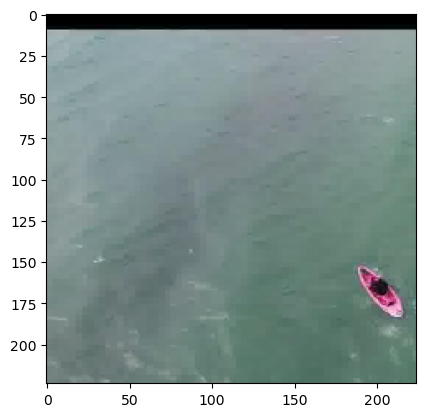

In [58]:
image_from_gen[0][0].shape

from matplotlib import pyplot as plt
plt.imshow(image_from_gen[0][0])
# So yes, the 224, denotes the size of the output image. But still not sure why this 224 and why the colour hasnt been normalised
# The colour is normalised, the imshow function works with inputs [0,1]